# Load data from JSON file
- Create empty dataframe
- Loop on every question/answer pair in the file
- Add a row to the dataframe for each pair

In [1]:
import json
import pandas as pd

question_df = pd.DataFrame(columns=["Question","Context","Text answer","Answer start"])

FILE_PATH = "../data/"

with open(FILE_PATH+'valid.json') as json_file:
    data = json.load(json_file)
    for book in data['data']:
        for paragraph in book['paragraphs']:
            for question in paragraph['qas']:
                row = pd.Series(data={'Question' : question['question'],
                                      'Context' : paragraph['context'],
                                      'Text answer': question['answers'][0]['answer_start'],
                                      'Answer start': question['answers'][0]['text']})
                question_df = question_df.append(row,ignore_index=True)

In [2]:
display(question_df)

,Question,Context,Text answer,Answer start
0,Que concerne principalement les documents ?,Les deux tableaux sont certes décrits par des ...,161,La Vierge aux rochers
1,Par quoi sont décrit les deux tableaux ?,Les deux tableaux sont certes décrits par des ...,46,documents contemporains
2,Quels types d'objets sont les deux tableaux au...,Les deux tableaux sont certes décrits par des ...,204,objets de spéculations
3,Sur quelle jambe les personnages se tiennent-t...,Les deux panneaux présentent de nombreuses sim...,242,droite
4,Quel pied avancent les personnages ?,Les deux panneaux présentent de nombreuses sim...,271,gauche
...,...,...,...,...
3183,A quel risque la zone où se situe la chapelle ...,La chapelle se trouvant dans une zone inondabl...,33,zone inondable
3184,Comment était disposés les murets par rapport ...,La chapelle se trouvant dans une zone inondabl...,210,perpendiculaires au courant
3185,En quelle matière sont les dalles du canal ?,La chapelle se trouvant dans une zone inondabl...,322,schiste
3186,Par quoi le canal est-il doublé ?,La chapelle se trouvant dans une zone inondabl...,479,par une digue


# Load the model

In [3]:
from gensim.models import KeyedVectors
import fasttext
# Load vector directly from the file
def load_model():
    try:
        # model = KeyedVectors.load_word2vec_format('../model/frWac_postag_no_phrase_1000_skip_cut100.bin', binary=True)
        model = fasttext.load_model("../model/cc.fr.300.bin")
        print("model loaded")
        return model
    except:
        print("model not found")
        
model = load_model()

model loaded


# Compute word vector

In [4]:
def get_WordVector(word,model):
    # Check if a word exists in the model
    try:
        vector = model[word]
        return vector
    except:
        print("Not found")

# Compute cosine distance between 2 words

In [5]:
from scipy import spatial

def get_cosine_distance(word_vec_1,word_vec_2):
    return (1 - spatial.distance.cosine(word_vec_1, word_vec_2))

In [6]:
print(get_cosine_distance(get_WordVector("manger",model),get_WordVector("pleurer",model)))

0.3769944906234741


# Compute sentence vector

In [34]:
from nltk.tokenize import word_tokenize

def tokenize(sentence): 
    return word_tokenize(sentence, language='french')
  
def get_SentenceVector(sentence,model):
    # splitted_sentence = tokenize(sentence)
    list_word_vectors = list()
    list_words = list()

    for word in sentence:
        word_vec = get_WordVector(word,model)
        list_word_vectors.append(word_vec)
        list_words.append(word)
    return sum(list_word_vectors)/len(sentence)

In [9]:
sentence_vec_1 = get_SentenceVector("Je mange des nougats le matin",model)
sentence_vec_2 = get_SentenceVector("Je mange des pommes",model)
print(get_cosine_distance(sentence_vec_1,sentence_vec_2))

sentence_vec_1 = get_SentenceVector("Je dors la nuit et je vole le jour",model)
sentence_vec_2 = get_SentenceVector("Je mange des pommes",model)
print(get_cosine_distance(sentence_vec_1,sentence_vec_2))

0.86665940284729
0.7887915968894958


# Remove stop words

In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
 
def rm_stop_words_nltk(sentence):
    stopWords = set(stopwords.words('french'))
    words = word_tokenize(sentence)
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    return wordsFiltered

In [11]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
final_stopwords_list = list(fr_stop)

def rm_stop_words_spacy(sentence):
    final_stopwords_list = list(fr_stop)
    words = word_tokenize(sentence)
    wordsFiltered = []
    for w in words:
        if w not in final_stopwords_list:
            wordsFiltered.append(w)
    return wordsFiltered

In [12]:
sentence = "Je dors la nuit et je vole le jour sur un lit qui fait la taille de une mongolfiere"
print(rm_stop_words_nltk(sentence))
print(rm_stop_words_spacy(sentence))

['Je', 'dors', 'nuit', 'vole', 'jour', 'lit', 'fait', 'taille', 'mongolfiere']
['Je', 'dors', 'nuit', 'vole', 'jour', 'lit', 'taille', 'mongolfiere']


# Remove all non-alphanumeric characters

In [22]:
def remove_non_alphanum_chars(sentence):
    return re.sub(r'([^\s\w]|_)+', '', sentence)

In [23]:
print(remove_non_alphanum_chars("Je m'appelle Basile, je suis pauvre. Je mange des gateaux."))

Je mappelle Basile je suis pauvre Je mange des gateaux


# Pre-Processing

In [30]:
def preprocess(sentence):
    # Add pre-processing steps
    sentence = remove_non_alphanum_chars(sentence)
    sentence = rm_stop_words_spacy(sentence)
    return sentence

# Split text into sentences

In [42]:
import nltk

list_len_context = list()

for index, row in question_df.iterrows():
    splitted_context = nltk.tokenize.sent_tokenize(row['Context'])
    list_len_context.append(len(splitted_context))
    for sentence in splitted_context:
        sentence = preprocess(sentence)
        if len(sentence) != 0:
            sentence_vector = get_SentenceVector(sentence,model)
            

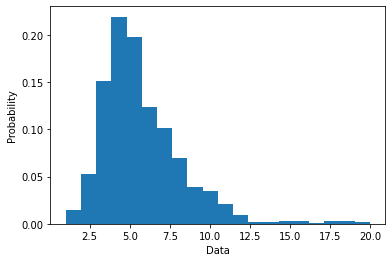

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.hist(list_len_context, density=True, bins=20)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [43]:
# Python program to get average of a list 
def Average(lst): 
    return sum(lst) / len(lst) 

print(Average(list_len_context))
print(max(list_len_context))
print(min(list_len_context))

5.4912170639899625
20
1


# Save the dataframe to a csv file

In [ ]:
def save(df):
    # Savess